**Predicting Pathologies In X-Ray Images**
~ Paul Mooney, December 2017

The NIH Clinical Center recently released over 100,000 anonymized chest x-ray images and their corresponding data to the scientific community. The release will allow researchers across the country and around the world to freely access the datasets and increase their ability to teach computers how to detect and diagnose disease. Ultimately, this artificial intelligence mechanism can lead to clinicians making better diagnostic decisions for patients.   

https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community

http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import cv2


Load the data

In [2]:
PATH = os.path.abspath(os.path.join('..', 'input'))
SOURCE_IMAGES = os.path.join(PATH, "sample", "images")
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

images[0:10]

['/kaggle/input/sample/images/00025846_001.png',
 '/kaggle/input/sample/images/00022881_008.png',
 '/kaggle/input/sample/images/00013934_000.png',
 '/kaggle/input/sample/images/00011890_001.png',
 '/kaggle/input/sample/images/00000390_000.png',
 '/kaggle/input/sample/images/00004342_020.png',
 '/kaggle/input/sample/images/00017138_013.png',
 '/kaggle/input/sample/images/00000524_001.png',
 '/kaggle/input/sample/images/00010176_000.png',
 '/kaggle/input/sample/images/00006271_026.png']

In [3]:
labels = pd.read_csv('../input/sample_labels.csv')
labels.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,0.139


Plot a representative image

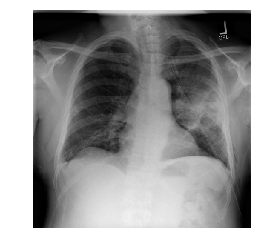

In [4]:
%matplotlib inline
image_name = "/kaggle/input/sample/images/00001256_007.png" #Image to be used as query
def plotImage(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (512,512))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotImage(image_name)

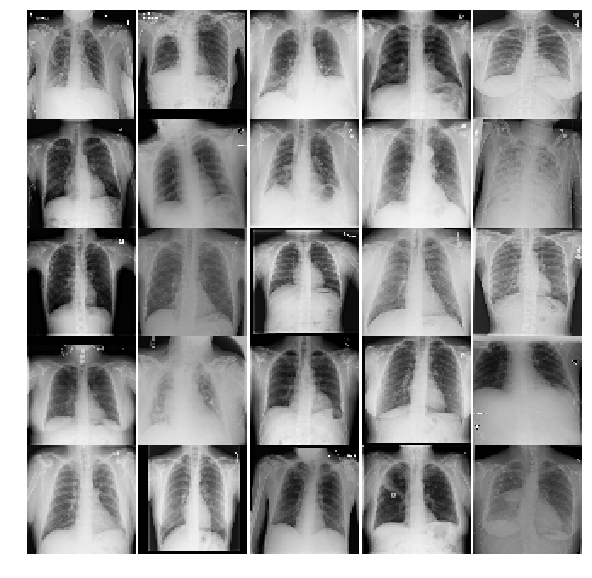

In [5]:
# Plot Multiple Images
simpsons = glob('/kaggle/input/sample/images/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in simpsons[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (64, 64)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

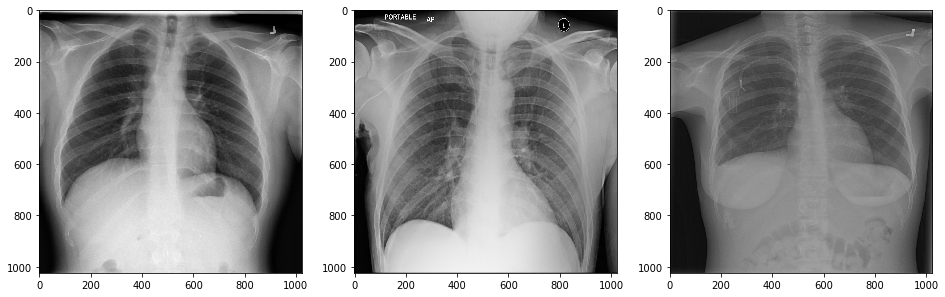

In [6]:
r = random.sample(images, 3)
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[0]))
plt.subplot(132)
plt.imshow(cv2.imread(r[1]))
plt.subplot(133)
plt.imshow(cv2.imread(r[2])); 

What types of ailments are identified in these annotated X-ray images?

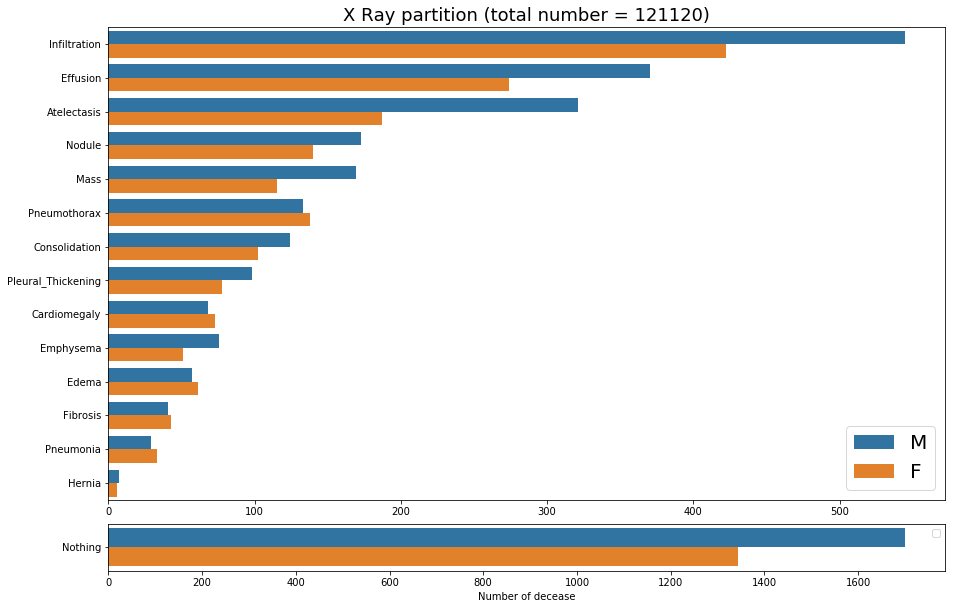

In [7]:
import matplotlib.gridspec as gridspec
import seaborn as sns


#drop unused columns
labels = labels[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]
#create new columns for each decease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
for pathology in pathology_list :
    labels[pathology] = labels['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
#remove Y after age
labels['Age']=labels['Patient Age'].apply(lambda x: x[:-1]).astype(int)

plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

labels['Nothing']=labels['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

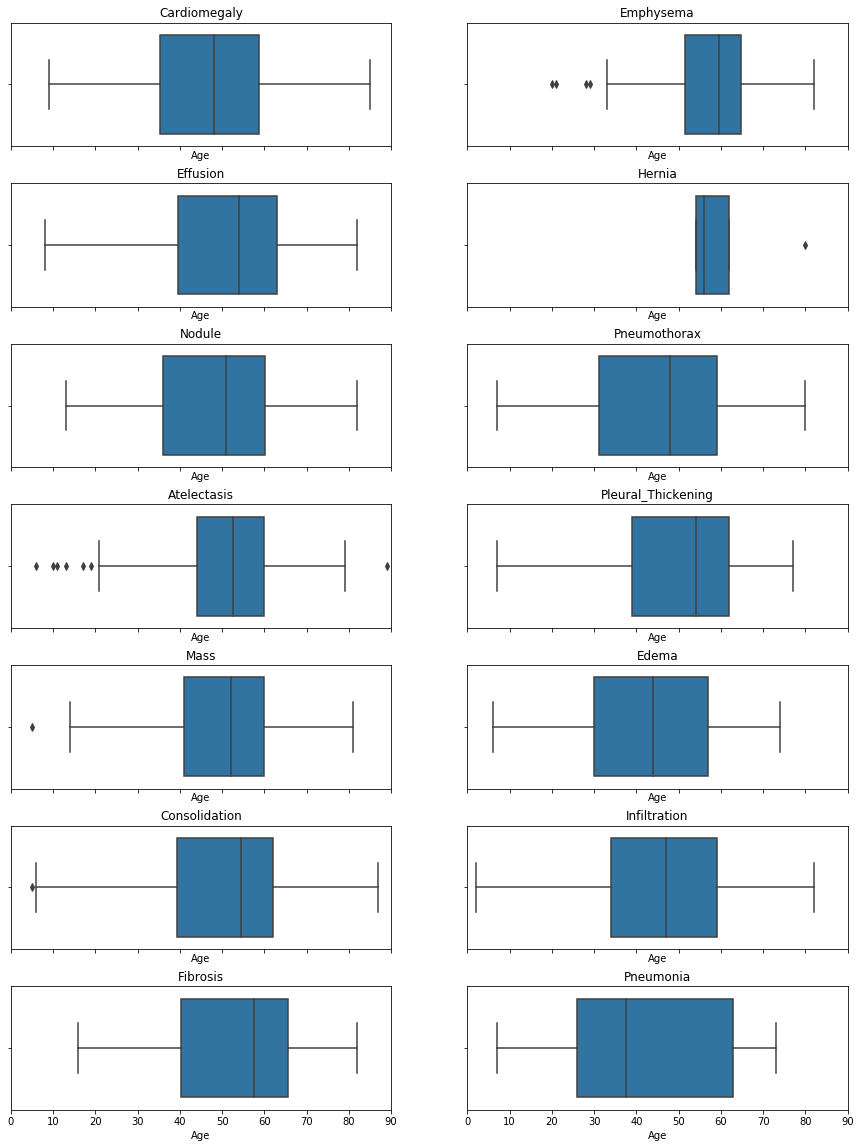

In [8]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))

i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    g=sns.boxplot(x='Age', hue="Patient Gender",data=labels[labels['Finding Labels']==pathology], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

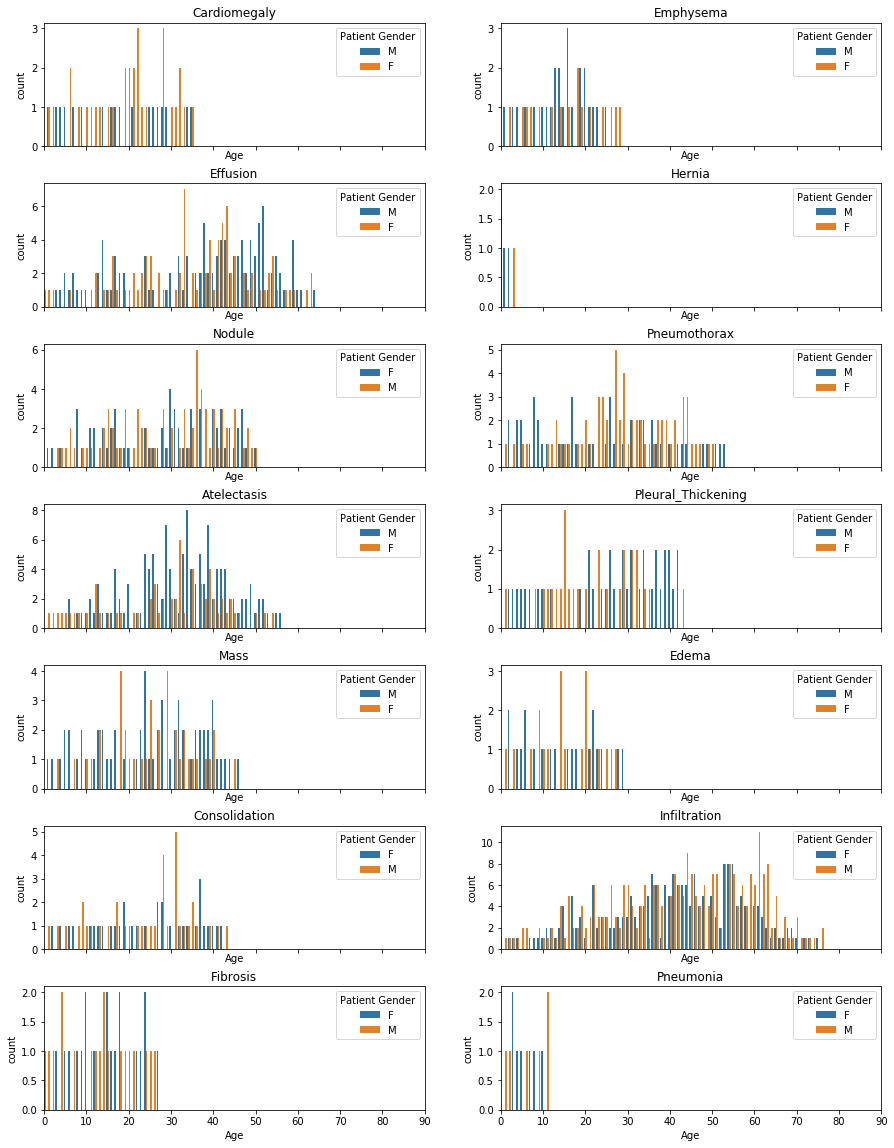

In [9]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))

i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    g=sns.countplot(x='Age', hue="Patient Gender",data=labels[labels['Finding Labels']==pathology], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

Convert annotated .png images into labeled numpy arrays

In [10]:
def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    NoFinding = "No Finding"
    Consolidation="Consolidation"
    Infiltration="Infiltration"
    Pneumothorax="Pneumothorax"
    Edema="Edema"
    Emphysema="Emphysema"
    Fibrosis="Fibrosis"
    Effusion="Effusion"
    Pneumonia="Pneumonia"
    Pleural_Thickening="Pleural_Thickening"
    Cardiomegaly="Cardiomegaly"
    NoduleMass="Nodule"
    Hernia="Hernia"
    Atelectasis="Atelectasis"   
    x = [] # images as arrays
    y = [] # labels Infiltration or Not_infiltration
    WIDTH = 64
    HEIGHT = 64
    for img in images:
        base = os.path.basename(img)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]
        # Read and resize image
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        # Labels
        if NoFinding in finding:
            finding = 0
            y.append(finding)        
        elif Consolidation in finding:
            finding = 1
            y.append(finding)    
        elif Infiltration in finding:
            finding = 2
            y.append(finding)           
        elif Pneumothorax in finding:
            finding = 3
            y.append(finding)
        elif Edema in finding:
            finding = 4
            y.append(finding)
        elif Emphysema in finding:
            finding = 5
            y.append(finding)
        elif Fibrosis in finding:
            finding = 6
            y.append(finding) 
        elif Effusion in finding:
            finding = 7
            y.append(finding)             
        elif Pneumonia in finding:
            finding = 8
            y.append(finding)   
        elif Pleural_Thickening in finding:
            finding = 9
            y.append(finding) 
        elif Cardiomegaly in finding:
            finding = 10
            y.append(finding) 
        elif NoduleMass in finding:
            finding = 11
            y.append(finding) 
        elif Hernia in finding:
            finding = 12
            y.append(finding) 
        elif Atelectasis in finding:
            finding = 13
            y.append(finding) 
        else:
            finding = 14
            y.append(finding)
    return x,y

# use a for loop to shorten this function
# put variables into a dictionary

In [11]:
X,y = proc_images()
df = pd.DataFrame()
df["images"]=X
df["labels"]=y
print(len(df), df.images[0].shape)
print(type(X))

5606 (64, 64, 3)
<class 'list'>


Describe new numpy arrays

In [12]:
dict_characters = {0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 
        3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7:'Effusion',
        8: 'Pneumonia', 9: 'Pleural_Thickening',10:'Cardiomegaly', 11: 'Nodule Mass', 
        12: 'Hernia', 13: 'Atelectasis'}

print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], ...       0
1  [[[9, 9, 9], [8, 8, 8], [7, 7, 7], [6, 6, 6], ...       0
2  [[[6, 6, 6], [4, 4, 4], [5, 5, 5], [11, 11, 11...      13
3  [[[34, 34, 34], [0, 0, 0], [0, 0, 0], [0, 0, 0...       7
4  [[[30, 30, 30], [28, 28, 28], [27, 27, 27], [2...       0
5  [[[7, 7, 7], [7, 7, 7], [7, 7, 7], [7, 7, 7], ...      10
6  [[[5, 5, 5], [4, 4, 4], [4, 4, 4], [4, 4, 4], ...       0
7  [[[2, 2, 2], [11, 11, 11], [16, 16, 16], [20, ...       6
8  [[[29, 29, 29], [12, 12, 12], [11, 11, 11], [1...       2
9  [[[193, 193, 193], [184, 184, 184], [177, 177,...       2

{0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural_Thickening', 10: 'Cardiomegaly', 11: 'Nodule Mass', 12: 'Hernia', 13: 'Atelectasis'}


Describe the distribution of pixel intensities within a representative image

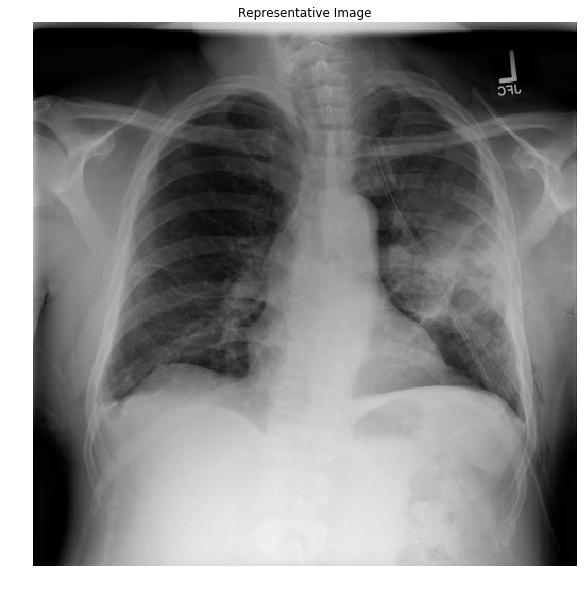

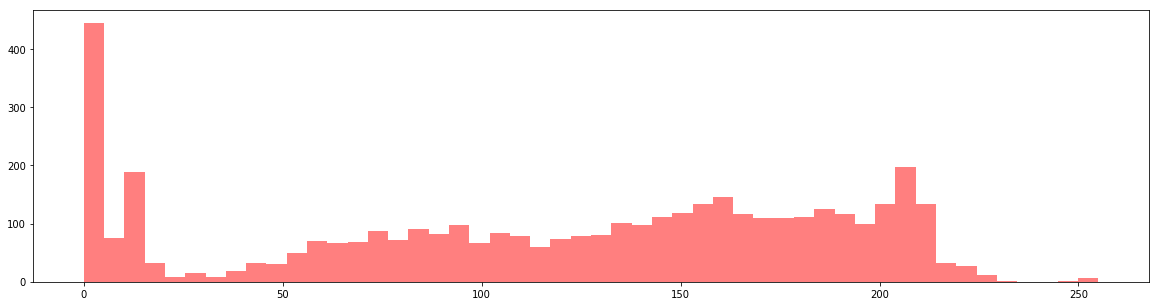

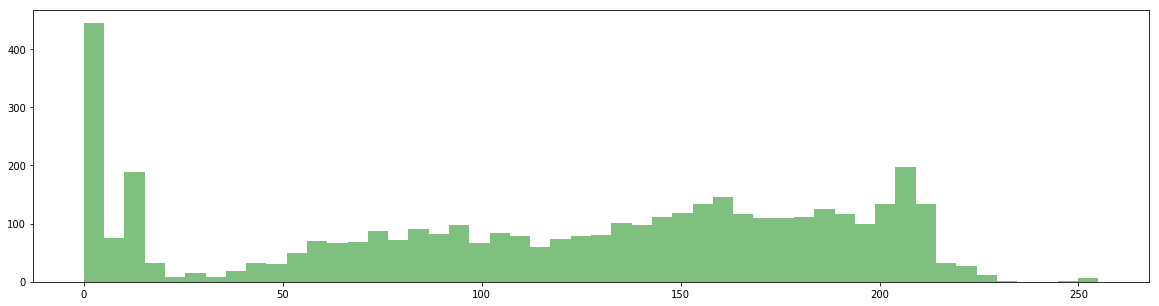

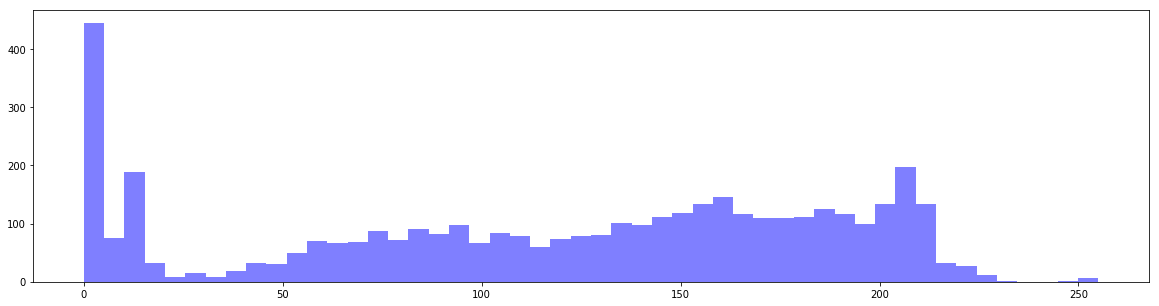

In [13]:
# We look at RGB histograms (represent colors). Histogram counts the number of pixels with a certain intensity
# between 0 and 255 for each color red, green and blue. A peak at 255 for all colors mean a lot of white ! 

i= 1 # Try 0, 1, 2.. for negative images and -1, -2, -3 for positive images and compare the histograms.
xi = X[i]


def plotArray(array):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (512,512))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotArray(xi)


# plt.imshow(xi)
# plt.axis('off')
plt.title('Representative Image')
plt.figure(figsize=(20,5))
n_bins = 50
plt.hist(xi[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.figure(figsize=(20,5))
plt.hist(xi[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
plt.figure(figsize=(20,5))
plt.hist(xi[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

Normalize the pixel intensities between zero and one.

In [14]:
X=np.array(X)
X=X/255.0

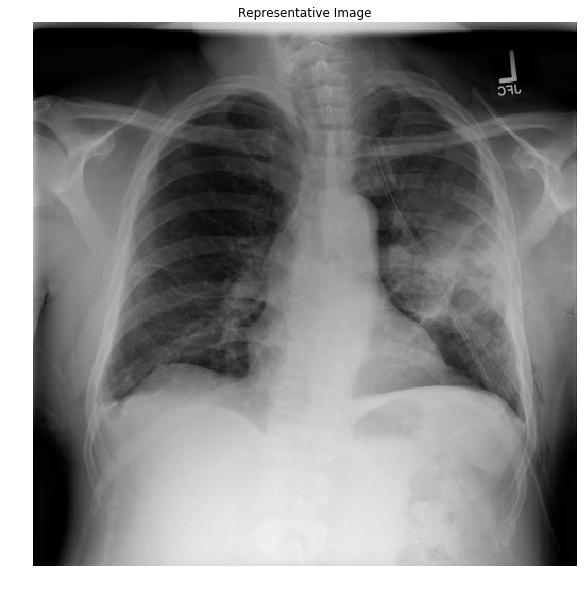

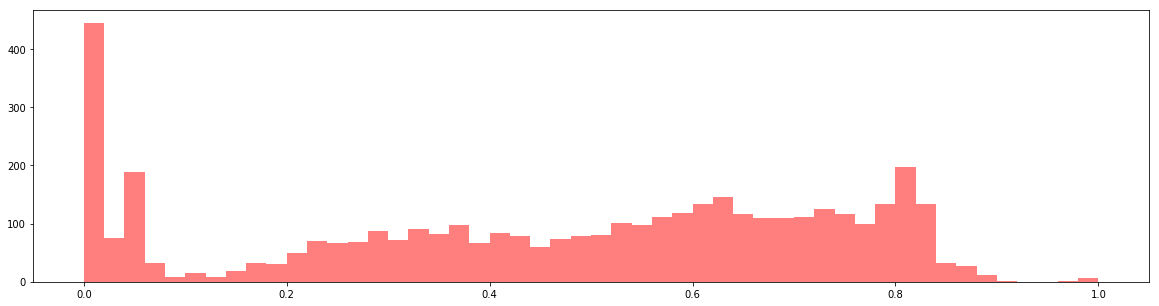

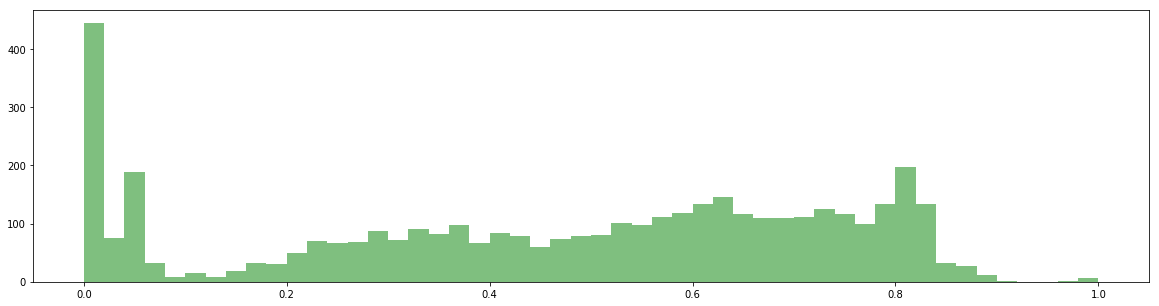

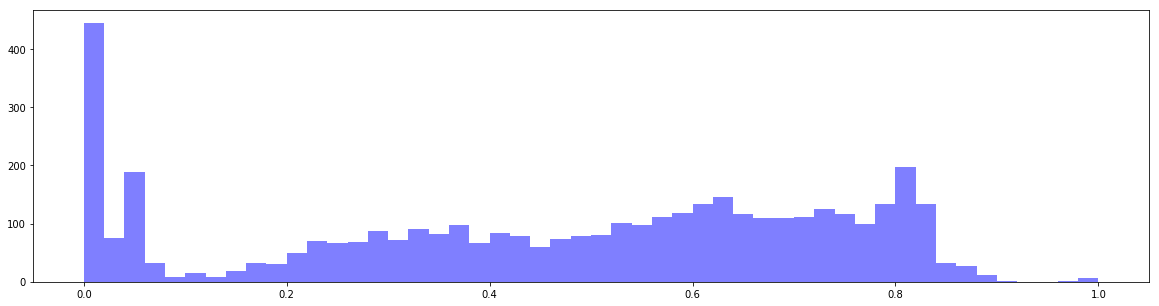

In [15]:
i= 1 # Try 0, 1, 2.. for negative images and -1, -2, -3 for positive images and compare the histograms.
xi = X[i]


def plotArray(array):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (512,512))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotArray(xi)


# plt.imshow(xi)
# plt.axis('off')
plt.title('Representative Image')
plt.figure(figsize=(20,5))
n_bins = 50
plt.hist(xi[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.figure(figsize=(20,5))
plt.hist(xi[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
plt.figure(figsize=(20,5))
plt.hist(xi[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

Describe distribution of class labels

{0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural_Thickening', 10: 'Cardiomegaly', 11: 'Nodule Mass', 12: 'Hernia', 13: 'Atelectasis'}


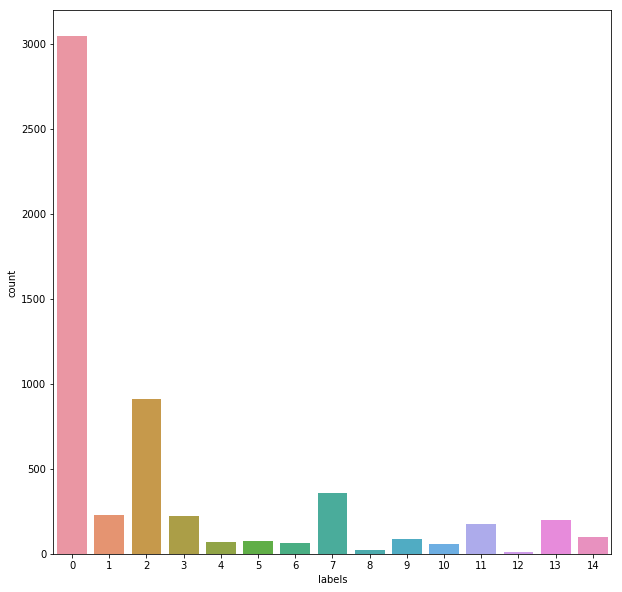

In [16]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)
#print(dist)

We have imbalanced sample sizes.  This is a problem that needs to be addressed.

But for now we can proceed with a preliminary analysis.

In [17]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import keras
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.utils import class_weight
import sklearn

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:5000] 
Y_train = Y_train[0:5000]
X_test = X_test[0:2000] 
Y_test = Y_test[0:2000]

In [19]:
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Data Shape:", len(X_train), X_train[0].shape)
print("Testing Data Shape:", len(X_test), X_test[0].shape)

Training Data Shape: (4484, 64, 64, 3)
Testing Data Shape: (1122, 64, 64, 3)
Training Data Shape: 4484 (64, 64, 3)
Testing Data Shape: 1122 (64, 64, 3)


Now I will try to use a CNN to predict each ailment based off of the X-Ray image.

In [20]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 20)
Y_testHot = to_categorical(Y_test, num_classes = 20)

In order to avoid having a biased model because of skewed class sizes, I will modify the class_weights parameter in order to give more weight to the rare classes.  In this case the class_weights parameter will eventually be passed to the model.fit function.

In [21]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print(class_weight)

[  0.12277705   1.65368732   0.41069597   1.69878788   5.57810945
   4.85367965   6.02795699   1.04981273  16.24927536   4.2469697
   6.79515152   2.14789272  46.71666667   1.89712352   3.77508418]


Epoch 1/3
141/140 [==============================] - 160s 1s/step - loss: 2.8787 - acc: 0.4552
Epoch 2/3
141/140 [==============================] - 161s 1s/step - loss: 1.9376 - acc: 0.5020
Epoch 3/3
141/140 [==============================] - 161s 1s/step - loss: 1.8303 - acc: 0.5286

Keras CNN #2B - accuracy: 0.554367201426



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 15, does not match size of target_names, 14
  .format(len(labels), len(target_names))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

        No Finding       0.55      1.00      0.71       622
     Consolidation       0.00      0.00      0.00        38
      Infiltration       0.00      0.00      0.00       186
      Pneumothorax       0.00      0.00      0.00        44
             Edema       0.00      0.00      0.00        11
         Emphysema       0.00      0.00      0.00        14
          Fibrosis       0.00      0.00      0.00        13
          Effusion       0.00      0.00      0.00        71
         Pneumonia       0.00      0.00      0.00         2
Pleural_Thickening       0.00      0.00      0.00        21
      Cardiomegaly       0.00      0.00      0.00        11
       Nodule Mass       0.00      0.00      0.00        34
            Hernia       0.00      0.00      0.00         1
       Atelectasis       0.00      0.00      0.00        39

       avg / total       0.31      0.55      0.40      1122



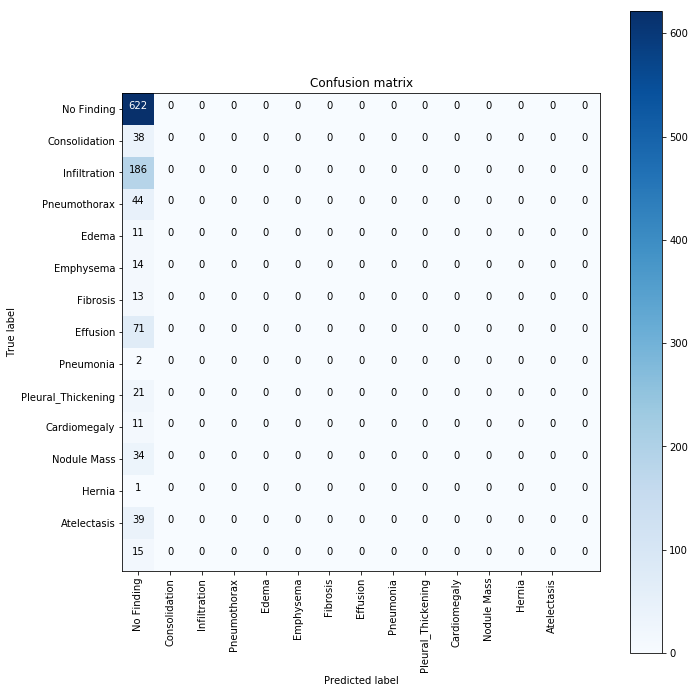

In [22]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    



def runCNNconfusion(a,b,c,d):

    # Set the CNN model 
    # my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
    
    batch_size = 128
    num_classes = 20
    epochs = 3
        
        # input image dimensions
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    #model.add(Dense(1024, activation = "relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "softmax"))
    
    # Define the optimizer
    optimizer = RMSprop(lr=0.001, decay=1e-6)
    
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(a)

    # fits the model on batches with real-time data augmentation:
    model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, class_weight = class_weight)



    score = model.evaluate(c,d, verbose=0)
        
    print('')
    print('Keras CNN #2B - accuracy:', score[1])
    print('')

    y_pred = model.predict(c)
    
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
   

    # Predict the values from the validation dataset
    Y_pred = model.predict(c)
    # Convert hot vectors prediction results to list of classes
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert hot vectors validation observations to list of classes
    Y_true = np.argmax(d,axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 

runCNNconfusion(X_train, Y_trainHot, X_test, Y_testHot)

The imbalance in our dataset has made our model biased in favor of the majority class (No Finding).  I tried to prevent this by modifying the class_weights parameter in the model.fit function but apparently that was not enough.  Now I will try to compensate for the imbalanced sample size by resampling or upsampling the minority classes.

In [23]:
newweights = class_weight*8
print(newweights)

[   0.98221638   13.22949853    3.28556777   13.59030303   44.62487562
   38.82943723   48.22365591    8.39850187  129.9942029    33.97575758
   54.36121212   17.18314176  373.73333333   15.17698816   30.2006734 ]


In [24]:
def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    NoFinding = "No Finding"
    Consolidation="Consolidation"
    Infiltration="Infiltration"
    Pneumothorax="Pneumothorax"
    Edema="Edema"
    Emphysema="Emphysema"
    Fibrosis="Fibrosis"
    Effusion="Effusion"
    Pneumonia="Pneumonia"
    Pleural_Thickening="Pleural_Thickening"
    Cardiomegaly="Cardiomegaly"
    NoduleMass="Nodule"
    Hernia="Hernia"
    Atelectasis="Atelectasis"
    
    x = [] # images as arrays
    y = [] # labels Infiltration or Not_infiltration
    WIDTH = 64
    HEIGHT = 64

    for img in images:
        base = os.path.basename(img)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]

        # Read and resize image
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
#1,13,3,13,44,39,48,8,129,33,54,17,374,15,30
        # Labels
        if NoFinding in finding:
            finding = 0
            y.append(finding)
        elif Consolidation in finding:
            finding = 1
            y.append(finding) 
            for i in range(13):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Infiltration in finding:
            finding = 2
            y.append(finding)
            for i in range(3):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Pneumothorax in finding:
            finding = 3
            y.append(finding)
            for i in range(13):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Edema in finding:
            finding = 4
            y.append(finding)
            for i in range(44):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Emphysema in finding:
            finding = 5
            y.append(finding)
            for i in range(39):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Fibrosis in finding:
            finding = 6
            y.append(finding) 
            for i in range(48):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Effusion in finding:
            finding = 7
            y.append(finding) 
            for i in range(8):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Pneumonia in finding:
            finding = 8
            y.append(finding)
            for i in range(129):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Pleural_Thickening in finding:
            finding = 9
            y.append(finding) 
            for i in range(33):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Cardiomegaly in finding:
            finding = 10
            y.append(finding) 
            for i in range(54):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif NoduleMass in finding:
            finding = 11
            y.append(finding) 
            for i in range(15):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Hernia in finding:
            finding = 12
            y.append(finding) 
            for i in range(374):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Atelectasis in finding:
            finding = 13
            y.append(finding) 
            for i in range(14):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        else:
            finding = 14
            y.append(finding)
    return x,y

# use a for loop to shorten this function

In [25]:
X2,y2 = proc_images()
dfNew = pd.DataFrame()
dfNew["images"]=X2
dfNew["labels"]=y2
X2=np.array(X2)
X2=X2/255.0
print(len(dfNew), dfNew.images[0].shape)

43110 (64, 64, 3)


{0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural_Thickening', 10: 'Cardiomegaly', 11: 'Nodule Mass', 12: 'Hernia', 13: 'Atelectasis'}


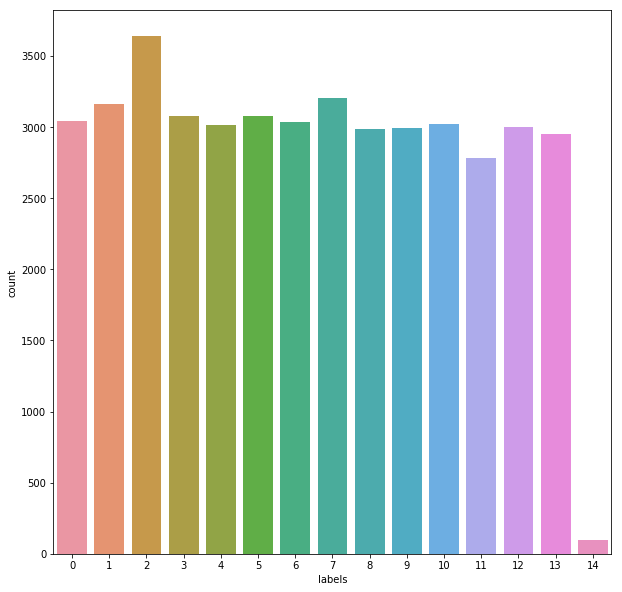

In [26]:
newLab = dfNew['labels']
newImg = dfNew['images']
dist = newLab.value_counts()
sns.countplot(newLab)
print(dict_characters)
#print(dist)

Now we have a much more even distriution of sample sizes for each of our 13 ailments (plus a 14th category for other/typos).  This should help make our model less biased in favor of the majority class (0=No Finding).

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X2, y2, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:40000] 
Y_train = Y_train[0:40000]
X_test = X_test[0:10000] 
Y_test = Y_test[0:10000]

In [28]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 20)
Y_testHot = to_categorical(Y_test, num_classes = 20)
print(X_train.shape)

(34488, 64, 64, 3)


In [29]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print(class_weight)

[  0.12277705   1.65368732   0.41069597   1.69878788   5.57810945
   4.85367965   6.02795699   1.04981273  16.24927536   4.2469697
   6.79515152   2.14789272  46.71666667   1.89712352   3.77508418]


Epoch 1/3
1078/1077 [==============================] - 1252s 1s/step - loss: 2.0966 - acc: 0.3540
Epoch 2/3
1078/1077 [==============================] - 1223s 1s/step - loss: 0.9227 - acc: 0.6999
Epoch 3/3
1078/1077 [==============================] - 1204s 1s/step - loss: 0.5709 - acc: 0.8171

Keras CNN #2B - accuracy: 0.914173045656



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 15, does not match size of target_names, 14
  .format(len(labels), len(target_names))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

        No Finding       0.55      0.61      0.58       640
     Consolidation       0.93      0.98      0.95       620
      Infiltration       0.71      0.66      0.69       713
      Pneumothorax       0.93      0.98      0.95       597
             Edema       1.00      1.00      1.00       631
         Emphysema       1.00      1.00      1.00       675
          Fibrosis       0.99      1.00      1.00       594
          Effusion       0.92      0.78      0.85       655
         Pneumonia       1.00      1.00      1.00       557
Pleural_Thickening       0.99      0.99      0.99       599
      Cardiomegaly       0.99      1.00      1.00       597
       Nodule Mass       0.95      0.95      0.95       567
            Hernia       1.00      1.00      1.00       572
       Atelectasis       0.91      0.95      0.93       584

       avg / total       0.91      0.91      0.91      8622



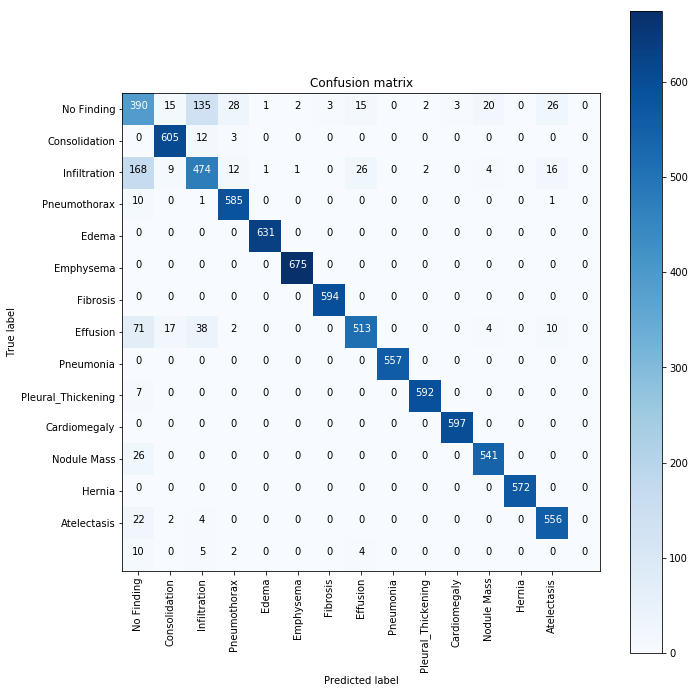

In [30]:
runCNNconfusion(X_train, Y_trainHot, X_test, Y_testHot)

That worked really well!

 To improve these predictions, try using the full and uncompressed dataset while running the code on a more powerful machine with an increased number of epochs.

To Do: 
1) Decide on optimal NN parameters and architecture
2) Decide on optimal data augmentation parameters
3) Plot learning curves for CNNs
4) Add representative images for each ailment
